# 20221219 Detrmining a Mask for Chambers Finding from Brightfield Image

I have a new plan to locate chambers and buttons from a "brightfield" image.
 1. First identify 4 corner chambers (for now this iwll be done by passing coordinates, but could be done in the future by prompting user for click inputs)
 2. use thse corners to programatically determine a chamber and lagoon mask with extra padding
 3. Run chamber and circle finding on the newly masked image

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import skimage
import glob
import imutils
from sklearn.linear_model import LinearRegression
import math
from copy import deepcopy
import pandas as pd
from collections import namedtuple

### Chamber location function
___

In [127]:
def find_chambers(img, chamber_rad: int, outer_chamber_bound: int, circle_param_1: int, circle_param_2: int):
    if type(img) == str:
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore") # Will throw warning due to precision loss
    #     cimg = skimage.img_as_ubyte(img, force_copy = True)
        
    # searchRadii
    min_rad = chamber_rad
    max_rad = min_rad + outer_chamber_bound

    # find circles
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=circle_param_1,param2=circle_param_2, minRadius=min_rad, maxRadius=max_rad)

    grad_threshold = circle_param_1
    # If no circles found, loosen gradient threshold
    while type(circles) is not np.ndarray and grad_threshold > 5:
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=grad_threshold, param2=circle_param_2, minRadius=min_rad+1, maxRadius=max_rad+2)
        grad_threshold -= 1

    # If still none found, return a blank chamber (failed)
    if not np.any(circles): 
        m = 'No chamber border found'
        warnings.warn(m)

    return circles[0]    

In [4]:
def get_rotation_adjustment(chamber_array: np.array, aligned_threshold: int = 75):
    # get left most 3 wells (min x-axis)
    min_x_chambers = chamber_array[chamber_array[:,0].argsort()[:3]]
    # remove radii
    min_x_chamber_coords = min_x_chambers[:,:2]
    # fit first pass model
    model = LinearRegression().fit(min_x_chamber_coords[:,0].reshape(-1,1), min_x_chamber_coords[:,1])

    pred_errors = model.predict(chamber_array[:,0].reshape(-1,1)) - chamber_array[:,1]

    updated_min_x_chambers = chamber_array[np.argwhere(pred_errors < aligned_threshold)].reshape(-1,3)

    updated_model = LinearRegression().fit(updated_min_x_chambers[:,0].reshape(-1,1), updated_min_x_chambers[:,1])

    rotation_angle = math.atan(updated_model.coef_)

    return rotation_angle


# Find Chambers from Brighftield

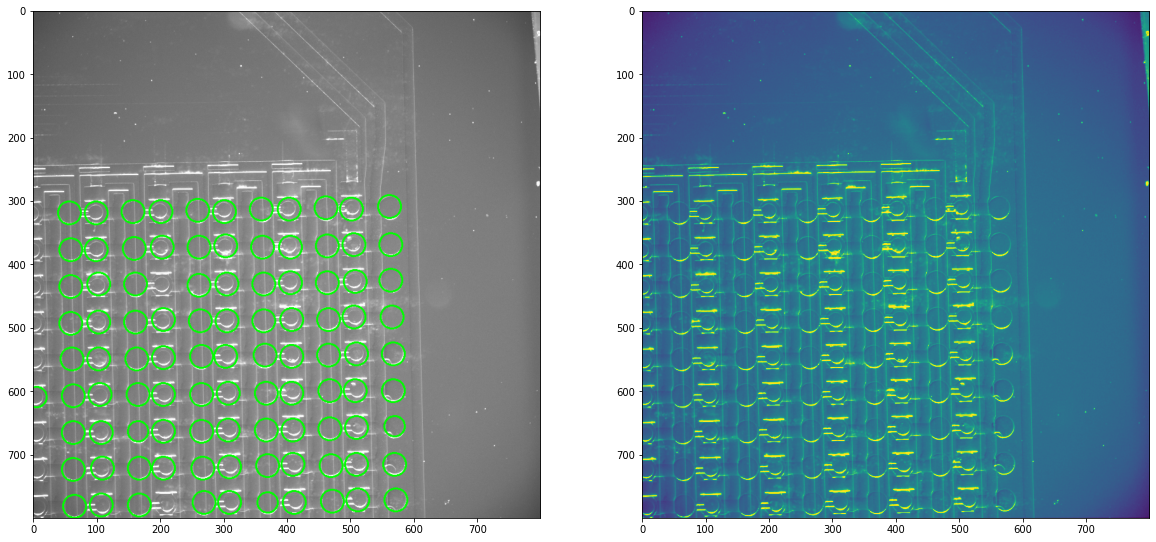

In [5]:
chamber_rad = 15
outer_chamber_bound = 4
circle_param_1 = 50
circle_param_2 = 40
grid_coords_raw = []


f, axarr = plt.subplots(1,2, figsize=(20,10))
rotation_angle = None

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# find circles in image
circles = find_chambers(img_path=img_path, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)

# find rotation adjustment
if rotation_angle is None:
    rotation_angle = get_rotation_adjustment(circles)

# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
output_image = imutils.rotate(img, angle=-rotation_angle)

axarr[1].imshow(output_image)  
axarr[0].imshow(full_color_img)

# looking at whole slide image

In [96]:
img_list = sorted(glob.glob("../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/*/*"))
imgs =[imutils.rotate(cv2.imread(img), angle=-1.15) for img in img_list]


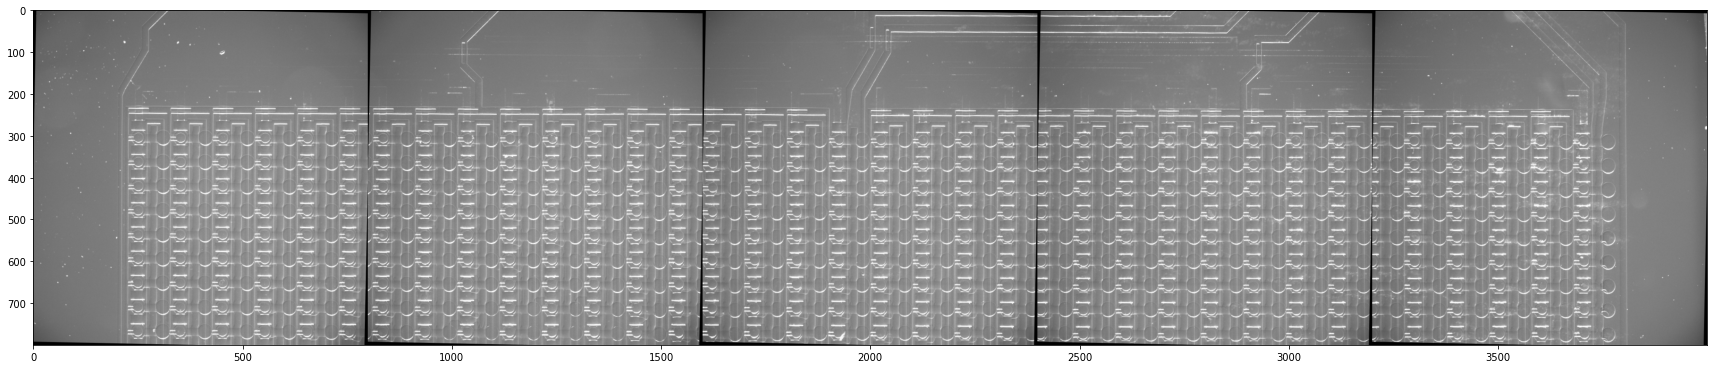

In [97]:
def concat_vh(list_2d):
    
      # return final image
    return cv2.vconcat([cv2.hconcat(list_h) 
                        for list_h in list_2d])

# function calling
img_tile = concat_vh([[imgs[20], imgs[15], imgs[10], imgs[5], imgs[0]]])
# show the output image
fig = plt.figure(figsize=(30,30))
plt.imshow(img_tile)

# Use corner chamber coordinates to interpolate a chamber mask

In [105]:
def rotate_image_coords(coords: tuple, angle, img_dim: int = 800) :
    img_mid = img_dim / 2
    x, y = coords
    angle = angle * math.pi / 180
    xr = (x - img_mid) * math.cos(angle) - (y - img_mid) * math.sin(angle) + img_mid
    yr = (x - img_mid) * math.sin(angle) + (y - img_mid) * math.cos(angle) + img_mid

    return int(xr), int(yr)

In [103]:
def calc_whole_slide_coords(raster_coords: tuple, raster_idx: tuple, image_dim: int = 800):
    return np.add(raster_coords, np.multiply((image_dim - image_dim / 10 ,image_dim - image_dim / 10), raster_idx))

In [39]:
def assign_raster_idx_from_whole_slide_coord(ws_coord: np.array, image_dim: int = 800):
    raster_idx = np.floor_divide(ws_coord, (image_dim - image_dim / 10 ,image_dim - image_dim / 10))
    return int(raster_idx[0]), int(raster_idx[1])

In [82]:
def calc_raster_image_coords(ws_coord: np.array, raster_idx: tuple, image_dim: int = 800):
    return np.uint16(np.subtract(ws_coord, np.multiply((image_dim - image_dim / 10 ,image_dim - image_dim / 10), raster_idx)))

In [107]:
STEVE_ROTATION = -1.15
top_right = (504, 313)
bottom_right = (498, 609)
top_left = (252, 307)
bottom_left = (245,606)

top_right_rotated = rotate_image_coords(top_right, STEVE_ROTATION)
bottom_right_rotated = rotate_image_coords(bottom_right, STEVE_ROTATION)
top_left_rotated = rotate_image_coords(top_left, STEVE_ROTATION)
bottom_left_rotated = rotate_image_coords(bottom_left, STEVE_ROTATION)

## Quadrilateral Interpolation Function from D. Mohktari Code

In [25]:
def quadrilateralInterp(corners, dims):
    """
    Grid the chip using the corners as vertices and the dims as the number of latice points
    in the x and y directions.

    Arguments:
        (tuple | namedtuple) corners: cornerpositions of the form 
            ((ULx, ULy),(URx, URy),(LLx, LLy),(LRx, LRy))
        (tuple) dims: chip dimensions (num columns, num rows)

    Returns:
        (np.ndarray) a 2-D array of latice (x, y) coordinates
    """

    def interp(p1, p2, divs):
        y = np.linspace(p1[0], p2[0], divs, dtype = int)
        x = np.linspace(p1[1], p2[1], divs, dtype = int)
        return np.stack((x, y), axis = 1)


    left = interp(corners.ul, corners.bl, dims[1])
    right = interp(corners.ur, corners.br, dims[1])
    mesh = [interp(p1, p2, dims[0]) for p1, p2 in zip(left, right)]
    return np.stack(mesh, axis = 1)

In [108]:
ChipCorner = namedtuple('Corners', ['ul', 'ur', 'bl', 'br'])

corners = ChipCorner(*(calc_whole_slide_coords(top_left_rotated, (0,0)), 
                    calc_whole_slide_coords(top_right_rotated, (4,0)), 
                    calc_whole_slide_coords(bottom_left_rotated, (0,4)), 
                    calc_whole_slide_coords(bottom_right_rotated, (4,4))))

In [113]:
chamber_centers = quadrilateralInterp(corners, (32,56))

In [114]:
assigned_raster_coords = np.apply_along_axis(assign_raster_idx_from_whole_slide_coord, 2, chamber_centers)

In [115]:
top_right_mask = (assigned_raster_coords == [4, 0]).all(axis=2)

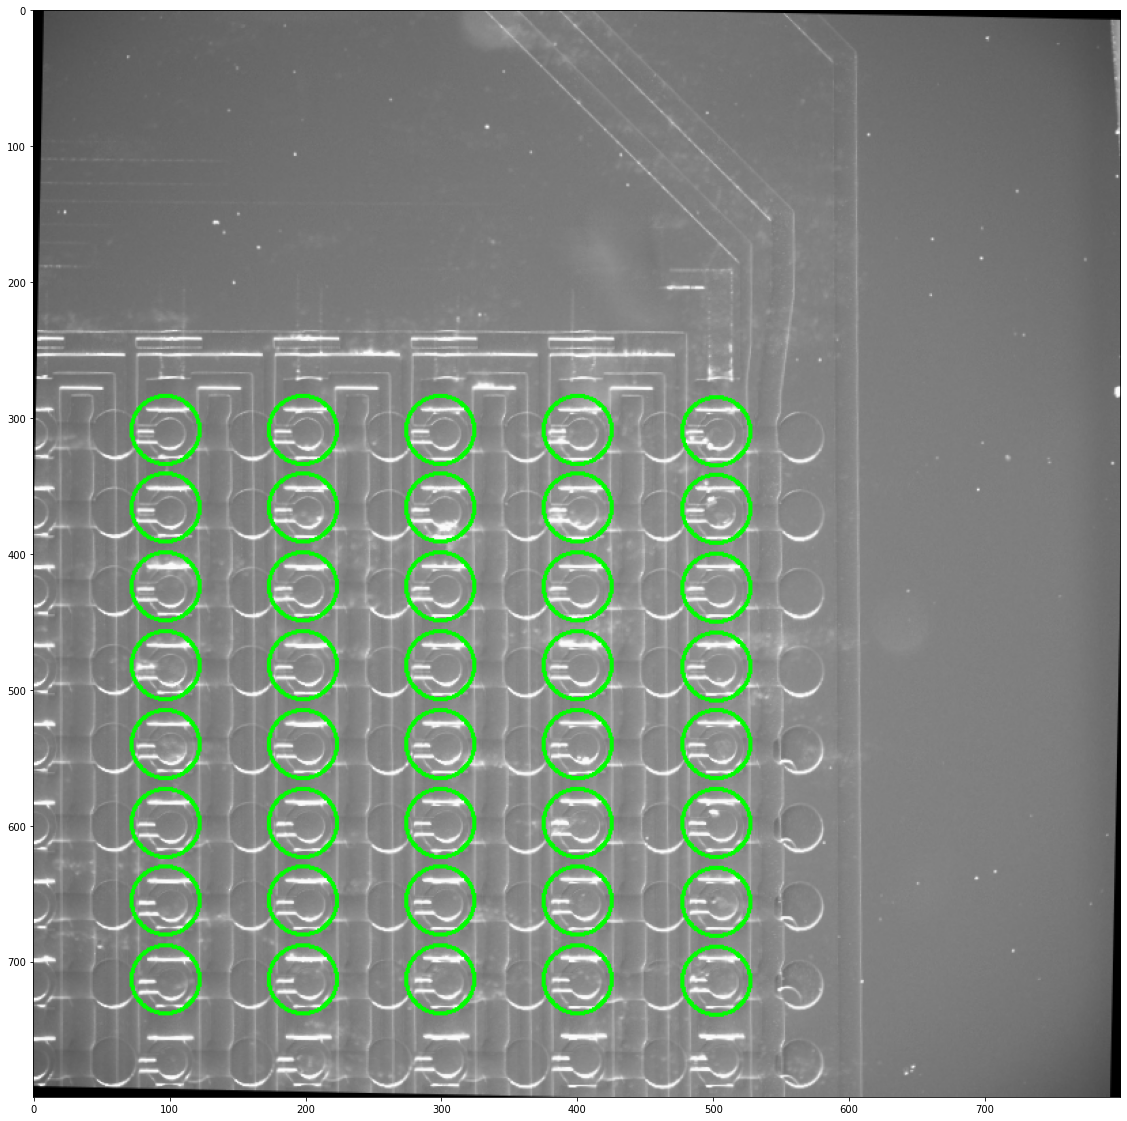

In [123]:
fig = plt.figure(figsize=(20,20))

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = imutils.rotate(cv2.imread(img_path), STEVE_ROTATION)

# Draw detected circles

for i in np.apply_along_axis(calc_raster_image_coords,1,chamber_centers[top_right_mask], (4,0)):
   
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), 25, (0, 255, 0), 2)

plt.imshow(full_color_img)

Next i'll need to read about masking, it looks like i may want to correct the initial center points byt creating an initial mask, then chamber finding and using new center

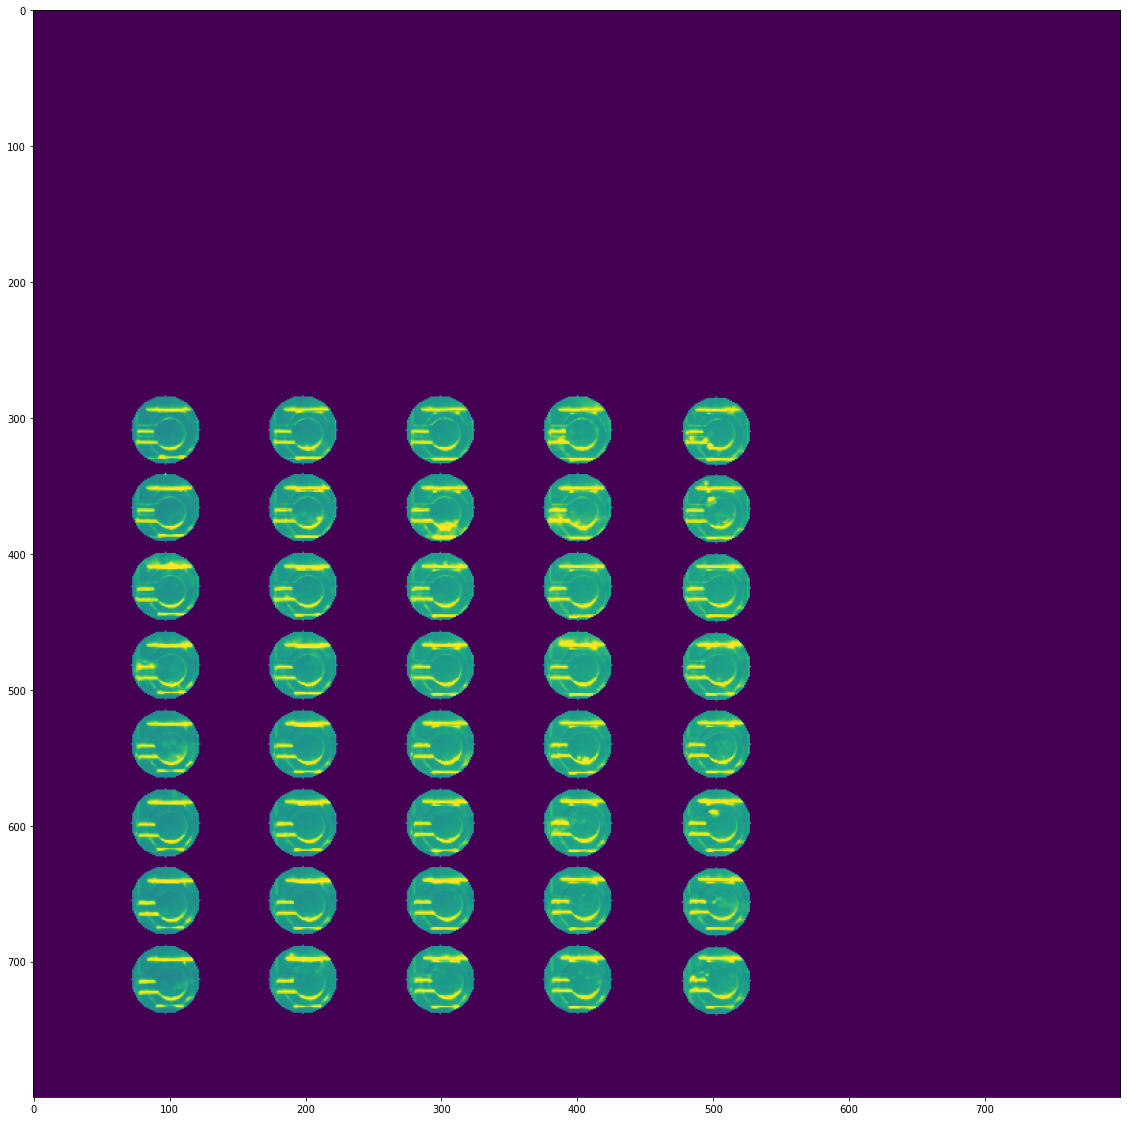

In [129]:
fig = plt.figure(figsize=(20,20))

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = imutils.rotate(img, STEVE_ROTATION)

# create mask
mask = np.zeros(img.shape, dtype=np.uint8)

for i in np.apply_along_axis(calc_raster_image_coords,1,chamber_centers[top_right_mask], (4,0)):
        
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        mask = cv2.circle(mask, (i[0], i[1]), 25, (255, 255, 255), -1)

masked = cv2.bitwise_and(img, mask)

plt.imshow(masked)

# Find Chambers from Brighftield with Masking

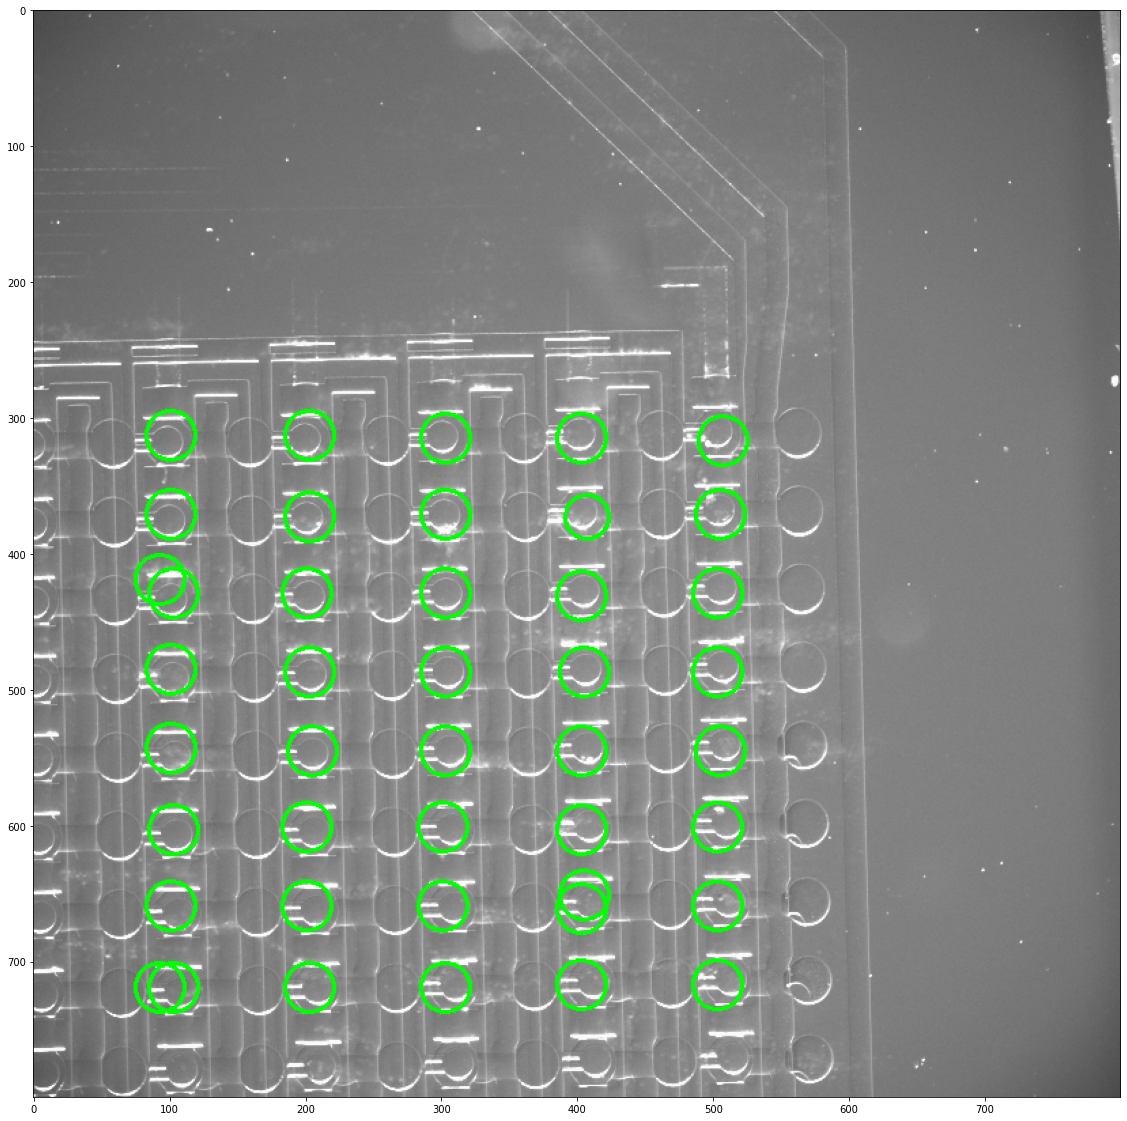

In [130]:
chamber_rad = 15
outer_chamber_bound = 4
circle_param_1 = 50
circle_param_2 = 40


fig = plt.figure(figsize=(20,20))

    
# find circles in image
circles = find_chambers(img=masked, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)


full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 255, 0), 2)

plt.imshow(full_color_img)